## to-do
2. Get POI data for Haarlem
    - Define area manually or use admin boundaries?
    - Start with OSM, see if we can find ratings there or some metric for popularity.
    - Then see if we need google maps
    - use saturated places algorithm for Google Maps
    - Confirm POI list that needs to pulled for either

2. Routing Algo
    - Look up relevant routing algorithms
    - Only walking paths? Or where walking is possible?
    - focus on FOSS
    - See how we can optimize for different types of POI
    - See how we can optimize for time for e.g. I don't walk to walk for more than 4 hours
    - Factor in time taken to see each location - smart algo or fixed time per attraction?
    - Factor in popularity of the location
    - Some compromise between popularity of the location vs time taken to get there? Basicall assign weights to edges? 
    - Starting location: Central train station?
    - Visualization: folium or kepler.gl?


## POI data extraction

In [31]:
import geopandas as gpd
import pandas as pd
import numpy as np
import requests as re
import osmnx as ox
import networkx as nx
import h3
import os
import ast
import tqdm
import shapely as shp
import time
import json
import folium

from shapely.ops import unary_union, transform
from ortools.constraint_solver import pywrapcp, routing_enums_pb2


In [2]:
file_path = '../config/API_KEY.json'
with open(file=file_path,mode= 'r') as f:
    json_data = json.load(f)
API_KEY = json_data['apiKey']

In [12]:
def func_visualize_hexagons(hexagons, color="red", folium_map=None):
    """
    original source: https://nbviewer.org/github/uber/h3-py-notebooks/blob/master/notebooks/usage.ipynb

    hexagons is a list of hexcluster. Each hexcluster is a list of hexagons. 
    eg. [[hex1, hex2], [hex3, hex4]]
    """
    polylines = []
    lat = []
    lng = []
    for hex in hexagons:
        polygons = h3.h3_set_to_multi_polygon([hex], geo_json=False)
        # Flatten polygons into loops.
        outlines = [loop for polygon in polygons for loop in polygon]
        polyline = [outline + [outline[0]] for outline in outlines][0]
        lat.extend(map(lambda v:v[0],polyline))
        lng.extend(map(lambda v:v[1],polyline))
        polylines.append(polyline)
    
    if folium_map is None:
        m = folium\
            .Map(location=[sum(lat)/len(lat),
                        sum(lng)/len(lng)],
                        zoom_start=9, 
                        tiles='cartodbpositron')
    else:
        m = folium_map
    for polyline in polylines:
        my_PolyLine=folium.PolyLine(locations=polyline,weight=2,color=color)
        m.add_child(my_PolyLine)
    return m

def func_get_hex_radius(row,BUFFER):
    edge_length = h3.edge_length(row.hex_resolution,'m')
    radius = edge_length
    radius = radius+edge_length*BUFFER
    return radius


In [ ]:
def func_get_places_poi(lat,lng,resolution,type,api_key):
    
    # Nearby sarch API URL
    url = "https://maps.googleapis.com/maps/api/place/nearbysearch/json"

    params = {
    'location': f'{lat},{lng}',
    'radius': resolution,
    'types': type,
    'key': api_key}

    response = re.get(url, params=params)
    places_df = []

    results = json.loads(response.content)

    places_df.append(results['results'])

    while 'next_page_token' in results:
        time.sleep(1)
        params['pagetoken'] = results['next_page_token']
        response = re.get(url,params=params)
        results = json.loads(response.content)
        places_df.append(results['results'])
        
    results_df = pd.concat([pd.DataFrame(df) for df in places_df])
    results_df = results_df.reset_index(drop=True)
    
    return results_df

# Location for Haarlem near Haarlem centraal
# lat,lng = 52.387111, 4.638286

# See all POI types for places API here: https://developers.google.com/maps/documentation/places/web-service/supported_types
# results_df = func_get_places_poi(lat=lat,lng=lng,
#                                  resolution=2000,
#                                  type='tourist_attraction', 
#                                  api_key=API_KEY)

# results_df[['place_id','name','types','user_ratings_total','vicinity']].head()
# results_df

,business_status,geometry,icon,icon_background_color,icon_mask_base_uri,name,opening_hours,photos,place_id,plus_code,rating,reference,scope,types,user_ratings_total,vicinity
0,OPERATIONAL,"{'location': {'lat': 52.39047799999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,Het Dolhuys,{'open_now': False},"[{'height': 3120, 'html_attributions': ['<a hr...",ChIJxfcBs3PvxUcReOojnqq1zx4,"{'compound_code': '9JRQ+56 Haarlem, Netherland...",4.0,ChIJxfcBs3PvxUcReOojnqq1zx4,GOOGLE,"[museum, tourist_attraction, cafe, food, store...",1080.0,"Schotersingel 2, Haarlem"
1,OPERATIONAL,"{'location': {'lat': 52.3810706, 'lng': 4.6373...",https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,The St. Bavo Church in Haarlem,{'open_now': False},"[{'height': 3024, 'html_attributions': ['<a hr...",ChIJFUIK6mvvxUcRqw1Oz3TX7yw,"{'compound_code': '9JJP+CW Haarlem, Netherland...",4.6,ChIJFUIK6mvvxUcRqw1Oz3TX7yw,GOOGLE,"[tourist_attraction, church, place_of_worship,...",3916.0,"Grote Markt 22, Haarlem"
2,OPERATIONAL,"{'location': {'lat': 52.3765894, 'lng': 4.6336...",https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,Frans Hals Museum,{'open_now': False},"[{'height': 2976, 'html_attributions': ['<a hr...",ChIJO9v2L0DvxUcRdU0VRVnyzUg,"{'compound_code': '9JGM+JF Haarlem, Netherland...",4.5,ChIJO9v2L0DvxUcRdU0VRVnyzUg,GOOGLE,"[tourist_attraction, museum, point_of_interest...",2890.0,"Groot Heiligland 62, Haarlem"
3,OPERATIONAL,"{'location': {'lat': 52.38115209999999, 'lng':...",https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,De Hallen Haarlem,{'open_now': False},"[{'height': 1670, 'html_attributions': ['<a hr...",ChIJwXIDmGvvxUcR-sbrPP5SCEs,"{'compound_code': '9JJP+FC Haarlem, Netherland...",3.9,ChIJwXIDmGvvxUcR-sbrPP5SCEs,GOOGLE,"[museum, tourist_attraction, point_of_interest...",495.0,"Grote Markt 16, Haarlem"
4,OPERATIONAL,"{'location': {'lat': 52.3803511, 'lng': 4.6403...",https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,Teylers Museum,{'open_now': False},"[{'height': 9000, 'html_attributions': ['<a hr...",ChIJbeZoEmnvxUcRLdbE56r1Ufo,"{'compound_code': '9JJR+44 Haarlem, Netherland...",4.5,ChIJbeZoEmnvxUcRLdbE56r1Ufo,GOOGLE,"[tourist_attraction, museum, point_of_interest...",4920.0,"Spaarne 16, Haarlem"
5,OPERATIONAL,"{'location': {'lat': 52.3773563, 'lng': 4.6308...",https://maps.gstatic.com/mapfiles/place_api/ic...,#7B9EB0,https://maps.gstatic.com/mapfiles/place_api/ic...,Proveniershuis,{'open_now': True},"[{'height': 3672, 'html_attributions': ['<a hr...",ChIJz59WVRXvxUcRWWkx0fZuBh8,"{'compound_code': '9JGJ+W8 Haarlem, Netherland...",4.2,ChIJz59WVRXvxUcRWWkx0fZuBh8,GOOGLE,"[tourist_attraction, point_of_interest, establ...",157.0,"Grote Houtstraat 142D, Haarlem"
6,OPERATIONAL,"{'location': {'lat': 52.3910141, 'lng': 4.6531...",https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,Barrel Organ Museum Haarlem,{'open_now': False},"[{'height': 2976, 'html_attributions': ['<a hr...",ChIJjwIPdnzvxUcRr0xJo-uq0Wo,"{'compound_code': '9MR3+C6 Haarlem, Netherland...",4.5,ChIJjwIPdnzvxUcRr0xJo-uq0Wo,GOOGLE,"[museum, tourist_attraction, point_of_interest...",111.0,"Küppersweg 3, Haarlem"
7,OPERATIONAL,"{'location': {'lat': 52.3892523, 'lng': 4.6379...",https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,De Bolwerken,{'open_now': True},"[{'height': 1600, 'html_attributions': ['<a hr...",ChIJa-SPXXLvxUcR7SESkcnvoJ0,"{'compound_code': '9JQQ+P5 Haarlem, Netherland...",4.6,ChIJa-SPXXLvxUcR7SESkcnvoJ0,GOOGLE,"[park, tourist_attraction, point_of_interest, ...",476.0,"De Bolwerken, MK, Haarlem"
8,OPERATIONAL,"{'location': {'lat': 52.3818564, 'lng': 4.6429...",https:/

In [11]:
place_name = "Haarlem, Netherlands"
# Get the boundary of the place
gdf = ox.geocode_to_gdf(place_name)
# Get the boundary polygon
haarlem_boundary = gdf.geometry.values[0]

In [12]:
centroid_haarlem = haarlem_boundary.centroid
m_ = folium.Map(location=[centroid_haarlem.y, centroid_haarlem.x], zoom_start=13)
# Add the boundary to the map
folium.GeoJson(
    haarlem_boundary.__geo_interface__,
    style_function=lambda x: {'color': 'blue', 'weight': 2, 'fillOpacity': 0.1}
).add_to(m_)
m_

In [6]:
# flip coordinate sequence from longitude, latitude to latitude, longitude as this is how the h3 API reads it
def flip(x,y):
    return y,x
haarlem_boundary = transform(flip,haarlem_boundary)

In [7]:
# Convert to plan geojson object
haarlem_boundary_geojson = gpd.GeoSeries([haarlem_boundary])\
    .__geo_interface__['features'][0]['geometry']

# Get h3 cell IDs for cells within the bounding polygon / geojson
res8_haarlem_hex = h3.polyfill(haarlem_boundary_geojson,8)

In [8]:
m = func_visualize_hexagons(hexagons=res8_haarlem_hex)
display(m)

In [9]:
res8_haarlem_hex = h3.polyfill(haarlem_boundary_geojson,8)
res9_haarlem_hex = h3.polyfill(haarlem_boundary_geojson,9)
res10_haarlem_hex = h3.polyfill(haarlem_boundary_geojson,10)

res8_haarlem_hex = pd.DataFrame({'hex_id':list(res8_haarlem_hex),'hex_resolution':8})
res9_haarlem_hex = pd.DataFrame({'hex_id':list(res9_haarlem_hex),'hex_resolution':9})
res10_haarlem_hex = pd.DataFrame({'hex_id':list(res10_haarlem_hex),'hex_resolution':10})
# Concatenate the three dataframes
haarlem_hex_df = pd.concat([res8_haarlem_hex,res9_haarlem_hex,res10_haarlem_hex],ignore_index=True)


In [ ]:
haarlem_hex_df['hex_area'] = haarlem_hex_df.hex_id.apply(lambda x: h3.cell_area(x,unit='m^2'))
haarlem_hex_df['hex_radius_places_api'] = haarlem_hex_df.apply(lambda row: func_get_hex_radius(row,0.15),axis=1)
haarlem_hex_df['centroid'] = haarlem_hex_df.hex_id.apply(lambda x: h3.h3_to_geo(x))

In [14]:
haarlem_hex_df.head()

,hex_id,hex_resolution,hex_area,hex_radius_places_api,centroid
0,8819682513fffff,8,615821.403749,530.557887,"(52.391097862889424, 4.670125339200063)"
1,88196825adfffff,8,615941.870444,530.557887,"(52.36678421945318, 4.635951467369167)"
2,881968251dfffff,8,615587.827867,530.557887,"(52.40471474475745, 4.662419418478945)"
3,8819682507fffff,8,615414.625032,530.557887,"(52.40617422858309, 4.6376171249224445)"
4,88196825a1fffff,8,616058.623742,530.557887,"(52.35997342987185, 4.639804615709505)"


In [25]:
max_haarlem_hex_def = haarlem_hex_df[haarlem_hex_df.hex_resolution==haarlem_hex_df.hex_resolution.min()]

# We created a seperate folder to store all output, in case the code is interrupted we can use
# this list to make sure we're not repeating any cells.

# searched_cells = os.listdir(f'../data/h3cell_output_cafe/')
# searched_cells = set([x.replace('.csv','') for x in searched_cells])

# Setting POI type for cafe.
# type = 'cafe'
ALL_TYPES = ['tourist_attraction','cafe','museum','art_gallery','park','restaurant','zoo',
             'art_gallery','theme_park', 'library','church','shopping_mall']

for type in ALL_TYPES:
    # Create a directory for each type if it doesn't exist
    if not os.path.exists(f'../data/h3cell_output_{type}/'):
        os.makedirs(f'../data/h3cell_output_{type}/')

    print(type)

    searched_cells = os.listdir(f'../data/h3cell_output_{type}/')
    # If the directory is empty, we can start from scratch
    if(len(searched_cells)>0):
        searched_cells = set([x.replace('.csv','') for x in searched_cells])

    # Loop through the hexagons and get the POI data
    for ind,row in tqdm.tqdm(max_haarlem_hex_def.iterrows(),
                            total=max_haarlem_hex_def.shape[0]):
        
        # Parsing the highest resolution cells and saving outputs in a csv file
        h3_cell = row.hex_id
        if(h3_cell not in searched_cells):
            lat,lng = row.centroid[0],row.centroid[1]
            resolution = row.hex_radius_places_api
            # Call the Places using the the function we wrote earlier
            df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
            df['hex_id'] = h3_cell
            cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
            df.to_csv(cell_save_path,index=False)
            
            # Key part of the algorithm, if the API returns equal or more than 60 results
            if(len(df)>=60):
                cell_children = h3.h3_to_children(df['hex_id'][0])
                child_df = haarlem_hex_df[haarlem_hex_df.hex_id.isin(cell_children)]
                
                # res 7 ~ 1400m
                for ind,row in child_df.iterrows():
                    h3_cell = row.hex_id
                    lat,lng = row.centroid[0],row.centroid[1]
                    resolution = row.hex_radius_places_api
                    df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
                    df['hex_id'] = h3_cell
                    cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
                    df.to_csv(cell_save_path,index=False)

                    # Repeat same logic as above and all other resolutions  
                    if(len(df)>=60):
                        cell_children = h3.h3_to_children(df['hex_id'][0])
                        child_df = haarlem_hex_df[haarlem_hex_df.hex_id.isin(cell_children)]

                        # res 8 ~ 500m
                        for ind,row in child_df.iterrows():
                            h3_cell = row.hex_id
                            lat,lng = row.centroid[0],row.centroid[1]
                            resolution = row.hex_radius_places_api
                            df = func_get_places_poi(lat=lat,lng=lng,resolution=resolution,type=type,api_key=API_KEY)
                            df['hex_id'] = h3_cell
                            cell_save_path = f'../data/h3cell_output_{type}/{h3_cell}.csv'
                            df.to_csv(cell_save_path,index=False)


tourist_attraction


  0%|          | 0/49 [00:00<?, ?it/s]

100%|██████████| 49/49 [00:09<00:00,  5.00it/s]


cafe


100%|██████████| 49/49 [00:15<00:00,  3.11it/s]


museum


100%|██████████| 49/49 [00:08<00:00,  5.95it/s]


art_gallery


100%|██████████| 49/49 [00:11<00:00,  4.42it/s]


park


100%|██████████| 49/49 [00:09<00:00,  5.15it/s]


restaurant


100%|██████████| 49/49 [00:22<00:00,  2.19it/s]


zoo


100%|██████████| 49/49 [00:08<00:00,  5.97it/s]


art_gallery


100%|██████████| 49/49 [00:00<00:00, 7410.16it/s]


theme_park


100%|██████████| 49/49 [01:13<00:00,  1.50s/it]


library


100%|██████████| 49/49 [00:08<00:00,  5.64it/s]


church


100%|██████████| 49/49 [00:09<00:00,  5.35it/s]


shopping_mall


100%|██████████| 49/49 [00:08<00:00,  5.71it/s]


In [ ]:
# read all the dataframes and concatenate them
paths = [] 
for type in ALL_TYPES:
    paths += [f'../data/h3cell_output_{type}/{x}' for x in os.listdir(f'../data/h3cell_output_{type}/')]
n_df = pd.concat([pd.read_csv(path) for path in paths])
n_df.place_id.nunique() # number of unique places

# write
# n_df.to_csv(f'../data/h3cell_output_all.csv',index=False)
# n_df.to_pickle(f'../data/h3cell_output_all.pkl')

1399

In [3]:
# read pickled data
n_df = pd.read_pickle(f'../data/h3cell_output_all.pkl')

In [4]:
n_df['geometry'] = n_df['geometry'].apply(lambda x: ast.literal_eval(x))
n_df['lat'] = n_df['geometry'].apply(lambda x: x['location']['lat'])
n_df['lng'] = n_df['geometry'].apply(lambda x: x['location']['lng'])
n_gdf = n_df.copy()
n_gdf['geometry'] = n_gdf['geometry'].apply(lambda row: shp.geometry.Point(row['location']['lat'],row['location']['lng']))
n_gdf = gpd.GeoDataFrame(n_gdf, geometry='geometry', crs='EPSG:4326')

In [5]:
map_ = folium.Map(location=[n_gdf.lat.mean(),
                            n_gdf.lng.mean()],
        zoom_start=13,
        tiles='cartodbpositron')
for i in range(len(n_gdf)):
    folium.CircleMarker(location=[n_gdf.iloc[i]['lat'], n_gdf.iloc[i]['lng']],
                  popup=n_gdf.iloc[i]['name'],
                  radius=5,
                  fill=True,
                  weight=1,
                  fill_opacity=1).add_to(map_)

In [6]:
map_

In [7]:
n_gdf.head()

,hex_id,business_status,geometry,icon,icon_background_color,icon_mask_base_uri,name,opening_hours,photos,place_id,...,rating,reference,scope,types,user_ratings_total,vicinity,permanently_closed,price_level,lat,lng
0,8819682511fffff,OPERATIONAL,POINT (52.3957 4.66541),https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,NZH Transport Museum,{'open_now': False},"[{'height': 282, 'html_attributions': ['<a hre...",ChIJOb3KvoHlxUcR4olr3LE0edA,...,4.6,ChIJOb3KvoHlxUcR4olr3LE0edA,GOOGLE,"['museum', 'tourist_attraction', 'point_of_int...",279.0,"A. Hofmanweg 35, Haarlem",NaN,NaN,52.395697,4.665406
1,8819682517fffff,OPERATIONAL,POINT (52.39101 4.65312),https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,Barrel Organ Museum Haarlem,{'open_now': False},"[{'height': 2976, 'html_attributions': ['<a hr...",ChIJjwIPdnzvxUcRr0xJo-uq0Wo,...,4.5,ChIJjwIPdnzvxUcRr0xJo-uq0Wo,GOOGLE,"['museum', 'tourist_attraction', 'point_of_int...",111.0,"Küppersweg 3, Haarlem",NaN,NaN,52.391014,4.653117
2,8819682531fffff,OPERATIONAL,POINT (52.39048 4.63806),https://maps.gstatic.com/mapfiles/place_api/ic...,#13B5C7,https://maps.gstatic.com/mapfiles/place_api/ic...,Het Dolhuys,{'open_now': False},"[{'height': 3120, 'html_attributions': ['<a hr...",ChIJxfcBs3PvxUcReOojnqq1zx4,...,4.0,ChIJxfcBs3PvxUcReOojnqq1zx4,GOOGLE,"['museum', 'tourist_attraction', 'cafe', 'stor...",1080.0,"Schotersingel 2, Haarlem",NaN,NaN,52.390478,4.638058
3,8819682531fffff,OPERATIONAL,POINT (52.39611 4.63583),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,Haarlemmer Kweektuin,{'open_now': False},"[{'height': 2988, 'html_attributions': ['<a hr...",ChIJ8UReJHXvxUcR_j0h1eSUV74,...,4.5,ChIJ8UReJHXvxUcR_j0h1eSUV74,GOOGLE,"['park', 'tourist_attraction', 'point_of_inter...",1026.0,"Kleverlaan 9, Haarlem",NaN,NaN,52.396111,4.635833
4,8819682533fffff,OPERATIONAL,POINT (52.38925 4.63794),https://maps.gstatic.com/mapfiles/place_api/ic...,#4DB546,https://maps.gstatic.com/mapfiles/place_api/ic...,De Bolwerken,{'open_now': True},"[{'height': 1600, 'html_attributions': ['<a hr...",ChIJa-SPXXLvxUcR7SESkcnvoJ0,...,4.6,ChIJa-SPXXLvxUcR7SESkcnvoJ0,GOOGLE,"['park', 'tourist_attraction', 'point_of_inter...",476.0,"De Bolwerken, MK, Haarlem",NaN,NaN,52.389252,4.637936


In [102]:
# Filtering for only relevant types and ratings

filtered_type_list = ['tourist_attraction','cafe','museum','art_gallery','park']
user_total_ratings = 10
rating = 3

filtered_n_gdf = n_gdf[(n_gdf['user_ratings_total']>=user_total_ratings) &
                        (n_gdf['rating']>=rating) &
                        (n_gdf['types'].apply(lambda x: any([i in x for i in filtered_type_list])))]
filtered_n_gdf = filtered_n_gdf.sort_values(by='user_ratings_total',ascending=False)
filtered_n_gdf = filtered_n_gdf.reset_index(drop=True)
filtered_n_gdf.shape

(153, 22)

## Routing algorithm

### Create distance and time matrix

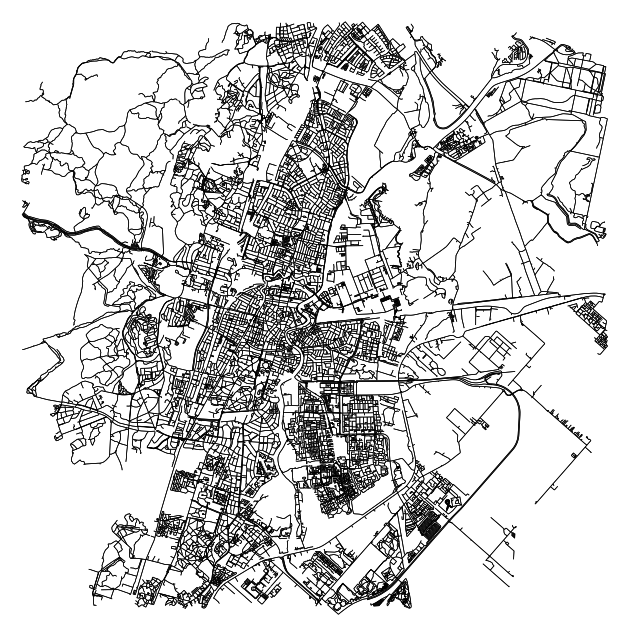

(<Figure size 800x800 with 1 Axes>, <Axes: >)

In [103]:
center_point_haarlem = (centroid_haarlem.y, centroid_haarlem.x)
radius = 6000 #10 km
G = ox.graph_from_point(center_point_haarlem, dist=radius, network_type='walk',simplify=True)
ox.plot_graph(G, node_size=0, edge_color='black', edge_linewidth=0.5, bgcolor='white')

In [104]:
# calculate distance matrix using OSM
filtered_n_gdf['nearest_node'] = ox.distance.nearest_nodes(G, filtered_n_gdf.lng, filtered_n_gdf.lat)
node_ids = filtered_n_gdf['nearest_node'].to_list()
n = len(node_ids)
dist_matrix = np.zeros((n, n))
for i, src in enumerate(node_ids):
    # print(i,src)
    lengths = nx.single_source_dijkstra_path_length(G, src,weight='length')
    for j, tgt in enumerate(node_ids):
        if tgt in lengths:
            dist_matrix[i, j] = lengths.get(tgt, np.inf)

In [105]:
dist_matrix_df = pd.DataFrame(dist_matrix, index=filtered_n_gdf.index, columns=filtered_n_gdf.index)
dist_matrix_df.head()

,0,1,2,3,4,5,6,7,8,9,...,143,144,145,146,147,148,149,150,151,152
0,0.000000,368.235702,832.700311,442.411961,472.932591,577.891078,525.232721,1361.376018,2177.166325,368.041008,...,671.422614,875.110150,3107.592255,1590.666773,2974.325990,3404.248832,2105.862628,175.570678,2166.880357,1254.512367
1,368.235702,0.000000,717.086404,74.176259,831.608406,209.655376,156.997019,1180.321781,2535.842140,134.114177,...,378.460037,506.874448,3130.523825,1409.612536,3166.834243,3712.207193,2298.370881,192.665024,2189.811928,1046.047434
2,832.700311,717.086404,0.000000,744.030954,1157.148516,830.499673,752.918973,1897.408185,2436.493080,582.972228,...,715.295292,925.666947,3847.610230,2126.698941,3663.343224,3476.217007,2794.879862,748.253804,2906.898332,421.812056
3,442.411961,74.176259,744.030954,0.000000,905.784665,135.479117,108.187876,1197.596600,2610.018399,161.058727,...,346.586370,458.065305,3147.798645,1426.887356,3194.586614,3779.687448,2326.123252,266.841283,2207.086748,1060.460431
4,472.932591,831.608406,1157.148516,905.784665,0.000000,1041.263782,988.605425,1608.873296,1871.874024,831.413713,...,1134.795318,1338.482854,2896.775496,1838.164052,2520.298134,3450.727592,1651.834772,638.943382,1964.218669,1552.692834


In [106]:
# calculcate time matrix
walking_speed_m_per_min = 80  # average walking speed in meters per minute
time_matrix_df = dist_matrix_df / walking_speed_m_per_min  # convert distance to time in minutes
time_matrix = dist_matrix / walking_speed_m_per_min
time_matrix = np.ceil(time_matrix).astype(int)

### Solve TSP using OR-Tools

In [ ]:
n = len(time_matrix)
max_total_time = 60 * 3 # 3 hours in minutes
SERVICE_TIME = 7 # 7 minutes service time at each location

# Create the routing model
manager = pywrapcp.RoutingIndexManager(n, 1, 0)    
routing = pywrapcp.RoutingModel(manager)

# Define the time callback function
def time_callback(from_idx, to_idx):
    from_node = manager.IndexToNode(from_idx)
    to_node = manager.IndexToNode(to_idx)
    return time_matrix[from_node][to_node] + (SERVICE_TIME if from_node != to_node else 0)  # Add service time to the travel time

# Register the transit callback
transit_callback_index = routing.RegisterTransitCallback(time_callback)
routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
routing.AddDimension(
    transit_callback_index,
    20,
    max_total_time,
    True,
    'Time'
)

## Allow fo skipping locaitons where different locaitons have different penalties depending on popularity
min_penalty = 1000
max_penalty = 10000
ratings = filtered_n_gdf['rating']
penalties = np.interp(ratings, (ratings.min(), ratings.max()), (min_penalty, max_penalty))

for node in range(1,len(filtered_n_gdf)):
    index = manager.NodeToIndex(node)
    penalthy = int(penalties[node])
    routing.AddDisjunction([index],penalthy)


# Set the search parameters
search_params = pywrapcp.DefaultRoutingSearchParameters()
search_params.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

# Find solution
solution = routing.SolveWithParameters(search_params)

In [176]:
route = []
index = routing.Start(0)
while not routing.IsEnd(index):
    node = manager.IndexToNode(index)
    route.append(node)
    index = solution.Value(routing.NextVar(index))
route.append(manager.IndexToNode(index))

### Visualize the route on the map

In [177]:
# Center the map on the first point
start_point = filtered_n_gdf.loc[route[0], 'geometry']
map_ = folium.Map(location=[start_point.x, start_point.y], zoom_start=16,tiles='cartodbpositron')

# Plot each POI in the route
for i, idx in enumerate(route):
    point = filtered_n_gdf.loc[idx, 'geometry']
    popup_text = f"{i+1}. {filtered_n_gdf.loc[idx, 'name']}" if 'name' in filtered_n_gdf.columns else f"Stop {i+1}"
    folium.CircleMarker(
        location=[point.x, point.y],
        popup=popup_text,
        fill_color='green',
        radius=7,
        fill_opacity=0.7,
        weight=0.1,
        icon=folium.Icon(color='blue', icon='info-sign')
    ).add_to(map_)

# Add lines connecting the POIs in route order
route_coords = [(filtered_n_gdf.loc[idx, 'geometry'].x, filtered_n_gdf.loc[idx, 'geometry'].y) for idx in route]
folium.PolyLine(route_coords, color='green', weight=3, opacity=0.8).add_to(map_)

# Show POIs that were filtered but not visited.
visited_set = set(route)
for idx, row in filtered_n_gdf.iterrows():
    if idx not in visited_set:
        folium.CircleMarker(
            location=[row.geometry.x, row.geometry.y],
            color='gray',
            fill=True,
            radius=3,
            fill_opacity=0.7,
            weight=0.1,
            popup=row['name'] if 'name' in row else str(idx)
        ).add_to(map_)

# Show the map
map_

In [184]:
map_.save('../viz/walkmap_haarlem_7min_3hours.html')